# INTRODUCTION

In this notebook, we explore the momentum trading strategy which consists of creating buying/selling signals based on various time framed sum moving averages (SMA) of an asset's price action or volume (2-days MA, 3-weeks MA). We follow the momentum of the price action by buying low and selling high.

In [1]:
# Pip install the required libraries
!pip install yfinance pandas-ta backtrader
!pip install backtrader[plotting]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 37.5 MB/s eta 0:00:00
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=64b96608f93536125de29faa2fc291a239105c65e9989e9850cb8bf204fbd778
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
# Import the required libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pandas_ta as ta
import backtrader as bt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
import backtrader.strategies as btstrats
from IPython.display import display
from google.colab import files
from IPython.display import Image

In [3]:
# Fetching information of Apple Inc (AAPL) stock from YahooFInance as a pandas dataframe
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2021-1-1", end="2021-12-31", interval="1d")
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,131.375698,131.464249,124.724260,127.331703,143301900,0.0,0.0
2021-01-05 00:00:00-05:00,126.820027,129.624262,126.367408,128.905975,97664900,0.0,0.0
2021-01-06 00:00:00-05:00,125.668842,128.945364,124.350358,124.566826,155088000,0.0,0.0
2021-01-07 00:00:00-05:00,126.298544,129.516033,125.806574,128.817429,109578200,0.0,0.0
2021-01-08 00:00:00-05:00,130.303193,130.499993,128.138528,129.929306,105158200,0.0,0.0


In [4]:
# Dataset shape
df_apple.shape

(251, 7)

The dataset consists of stock parameters for 251 days.

In [5]:
# Compute the 5-d, 15-d and 25-d SMA for visualization
df_apple["5d_sma_price"] = df_apple['Close'].rolling(5).mean()
df_apple["15d_sma_price"] = df_apple['Close'].rolling(15).mean()
df_apple["25d_sma_price"] = df_apple['Close'].rolling(25).mean()

# The 25-d SMA for trading volume
df_apple["25d_sma_volume"] = df_apple['Volume'].rolling(25).mean()
df_apple = df_apple[df_apple["25d_sma_price"].notna()]
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,5d_sma_price,15d_sma_price,25d_sma_price,25d_sma_volume
Date,,,,,,,,,,,
2021-02-08 00:00:00-05:00,134.045371,134.961810,132.951565,134.912537,71297200,0.0,0.0,133.894366,134.309727,131.542519,110034488.0
2021-02-09 00:00:00-05:00,134.626782,135.868408,133.868026,134.025681,76774200,0.0,0.0,134.135083,134.859634,131.810278,107373380.0
2021-02-10 00:00:00-05:00,134.488828,134.991397,132.439172,133.414734,73046600,0.0,0.0,134.460242,135.093310,131.990628,106388648.0
2021-02-11 00:00:00-05:00,133.917279,134.400135,131.818365,133.158524,64280000,0.0,0.0,134.055240,134.992419,132.334296,102756328.0
2021-02-12 00:00:00-05:00,132.389912,133.552689,131.739537,133.395020,60145100,0.0,0.0,133.781299,134.762983,132.517400,100779004.0


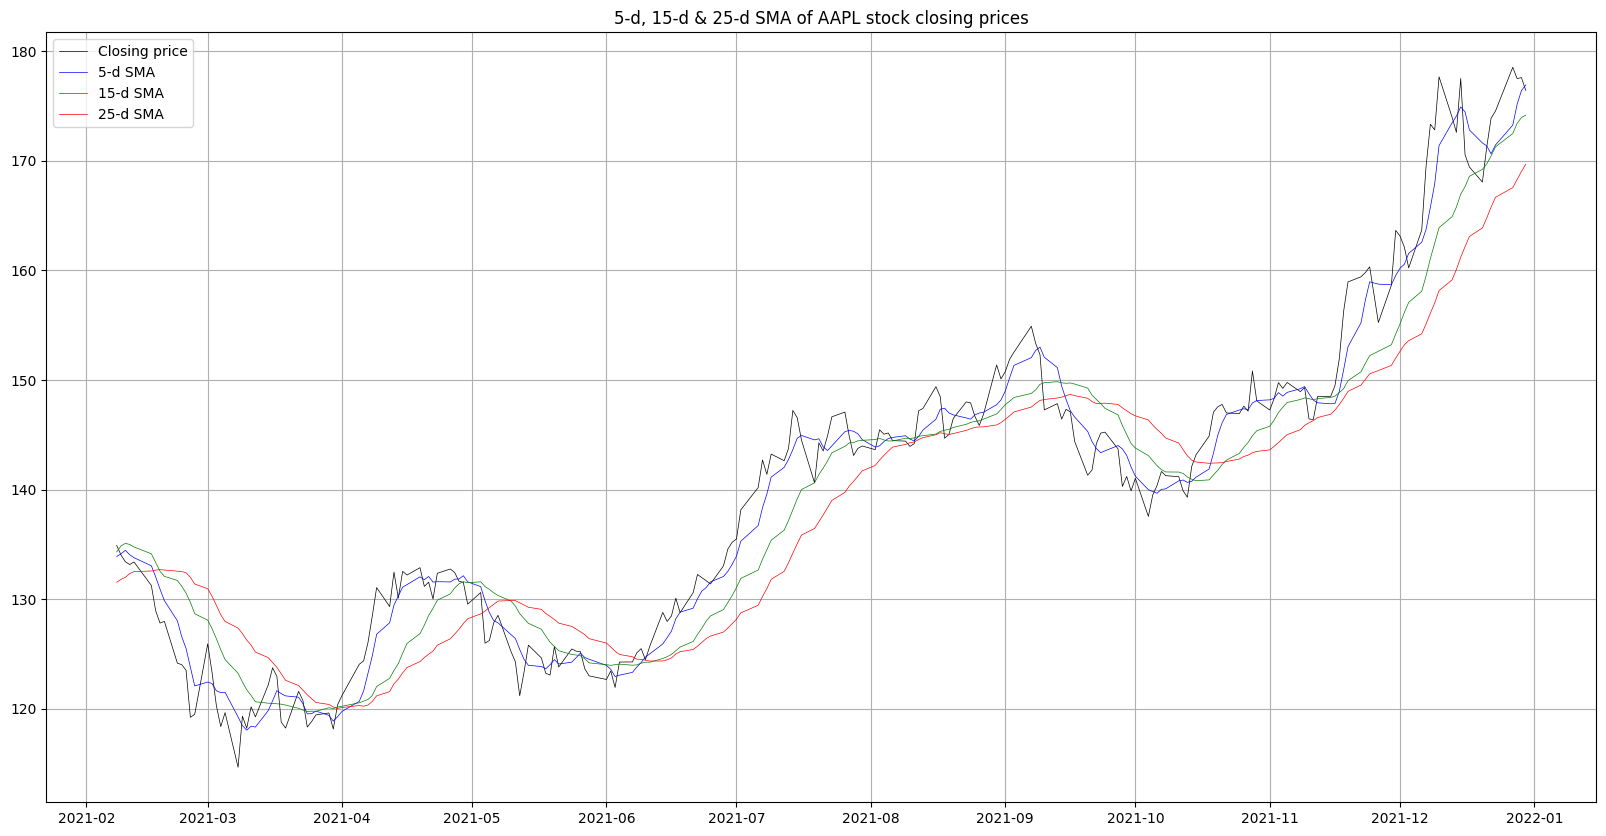

In [6]:
# Plotting the SMAs in a graph
plt.figure(figsize=(20, 10))
plt.plot(df_apple['Close'], color='black', linewidth=0.5, label='Closing price')
plt.plot(df_apple['5d_sma_price'], color='blue', linewidth=0.5, label='5-d SMA')
plt.plot(df_apple['15d_sma_price'], color='green', linewidth=0.5, label='15-d SMA')
plt.plot(df_apple['25d_sma_price'], color='red', linewidth=0.5, label='25-d SMA')
plt.title("5-d, 15-d & 25-d SMA of AAPL stock closing prices")
plt.legend(loc='best')
plt.grid()
plt.show()

# CREATE BUY/SELL SIGNALS USING BACKTRADING

In [7]:
# Backtesting parameters
data = bt.feeds.PandasData(dataname=yf.download('AAPL', start="2021-1-1", end="2021-12-31", interval="1d"))
startcash = 1000000
commission = 0.002
stake = 1000

[*********************100%%**********************]  1 of 1 completed


In [8]:
class TradeLogger(bt.analyzers.Analyzer):
    """
    Analyzer returning closed trades information.
    """

    def start(self):
        super(TradeLogger, self).start()

    def create_analysis(self):
        self.rets = []
        self.vals = dict()

    def notify_trade(self, trade):
        """Receives trade notifications before each next cycle"""
        if trade.isclosed:
            self.vals = {'Date': self.strategy.datetime.datetime(),
                         'Gross PnL': round(trade.pnl, 2),
                         'Net PnL': round(trade.pnlcomm, 2),
                         'Trade commission': trade.commission,
                         'Trade duration (in days)': (trade.dtclose - trade.dtopen)
            }
            self.rets.append(self.vals)

    def get_analysis(self):
        return self.rets


def set_and_run(data, strategy, startcash, commission, stake):
    # Initialize cerebro engine, add the strategy and initial capital
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy)
    cerebro.adddata(data)
    cerebro.broker.setcash(startcash)
    print("Starting Portfolio Value: {}".format(cerebro.broker.getvalue()))

    # Set the broker commission
    cerebro.broker.setcommission(commission)

    # Number of shares to buy/sell
    cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

    # Add evaluation metrics
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(TradeLogger, _name="trade_logger")

    results = cerebro.run()
    print("Final Portfolio Value: {}".format(cerebro.broker.getvalue()))
    print("Sharpe Ratio: {}".format(results[0].analyzers.sharperatio.get_analysis()['sharperatio']))
    display(pd.DataFrame(results[0].analyzers.trade_logger.get_analysis()))

    return cerebro

# First strategy: SMA of close price & trading volume

- After computing the SMAs, we establish a strategy that will generate a buy or sell signal. The strategy will be: when the asset's close price is below the its SMA, and the volume is above the its SMA it's a buying signal, and vice versa for selling.

- Next, we'll backtest the number of days over which we compute our SMA for close price and volume, we'll finally take the values having the best Sharpe ratio.

In [9]:
class FirstStrategy(bt.Strategy):
    params = (('close_period', 5),
              ('volume_period', 4)
    )

    def __init__(self):
        self.close_sma = bt.indicators.SMA(self.data.close, period=self.params.close_period)
        self.volume_sma = bt.indicators.SMA(self.data.volume, period=self.params.volume_period)

    def next(self):
        if not self.position:
            if self.data.close < self.close_sma and self.data.volume > self.volume_sma:
                self.buy()
        else:
            if self.data.close > self.close_sma and self.data.volume < self.volume_sma:
                self.sell()

In [10]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(FirstStrategy,
                             close_period=range(2, 25),
                             volume_period=range(2, 25))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission)
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Close period": result[0].params.close_period,
                           "Volume period": result[0].params.volume_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'],
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])

display(df_result.sort_values("Sharpe ratio", ascending=False))

,Close period,Volume period,Sharpe ratio,Variability weighted return (in %)
71,5,4,0.130736,5.115155
94,6,4,0.126631,4.946450
48,4,4,0.115738,4.438497
72,5,5,0.100979,4.157204
73,5,6,0.094093,3.975228
...,...,...,...,...
515,24,11,-0.074222,-1.684503
514,24,10,-0.074222,-1.684503
429,20,17,-0.074799,-1.559862
421,20,9,-0.075241,-1.668425


Starting Portfolio Value: 1000000
Final Portfolio Value: 1055787.0186920166
Sharpe Ratio: 2.497704443808068


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-01-27,15649.99,15107.57,542.419983,8.0
1,2021-02-05,1520.00,973.64,546.360016,7.0
2,2021-03-02,-2840.00,-3359.32,519.320007,13.0
3,2021-03-10,710.00,224.66,485.340012,5.0
4,2021-03-23,3430.00,2943.54,486.460007,4.0
5,2021-03-30,-240.00,-720.92,480.919998,4.0
6,2021-04-26,2470.00,1935.62,534.380005,5.0
7,2021-05-10,-7060.00,-7591.76,531.760010,11.0
8,2021-05-17,3320.00,2819.36,500.639999,6.0
9,2021-05-25,2590.00,2083.90,506.100006,5.0


<IPython.core.display.Javascript object>

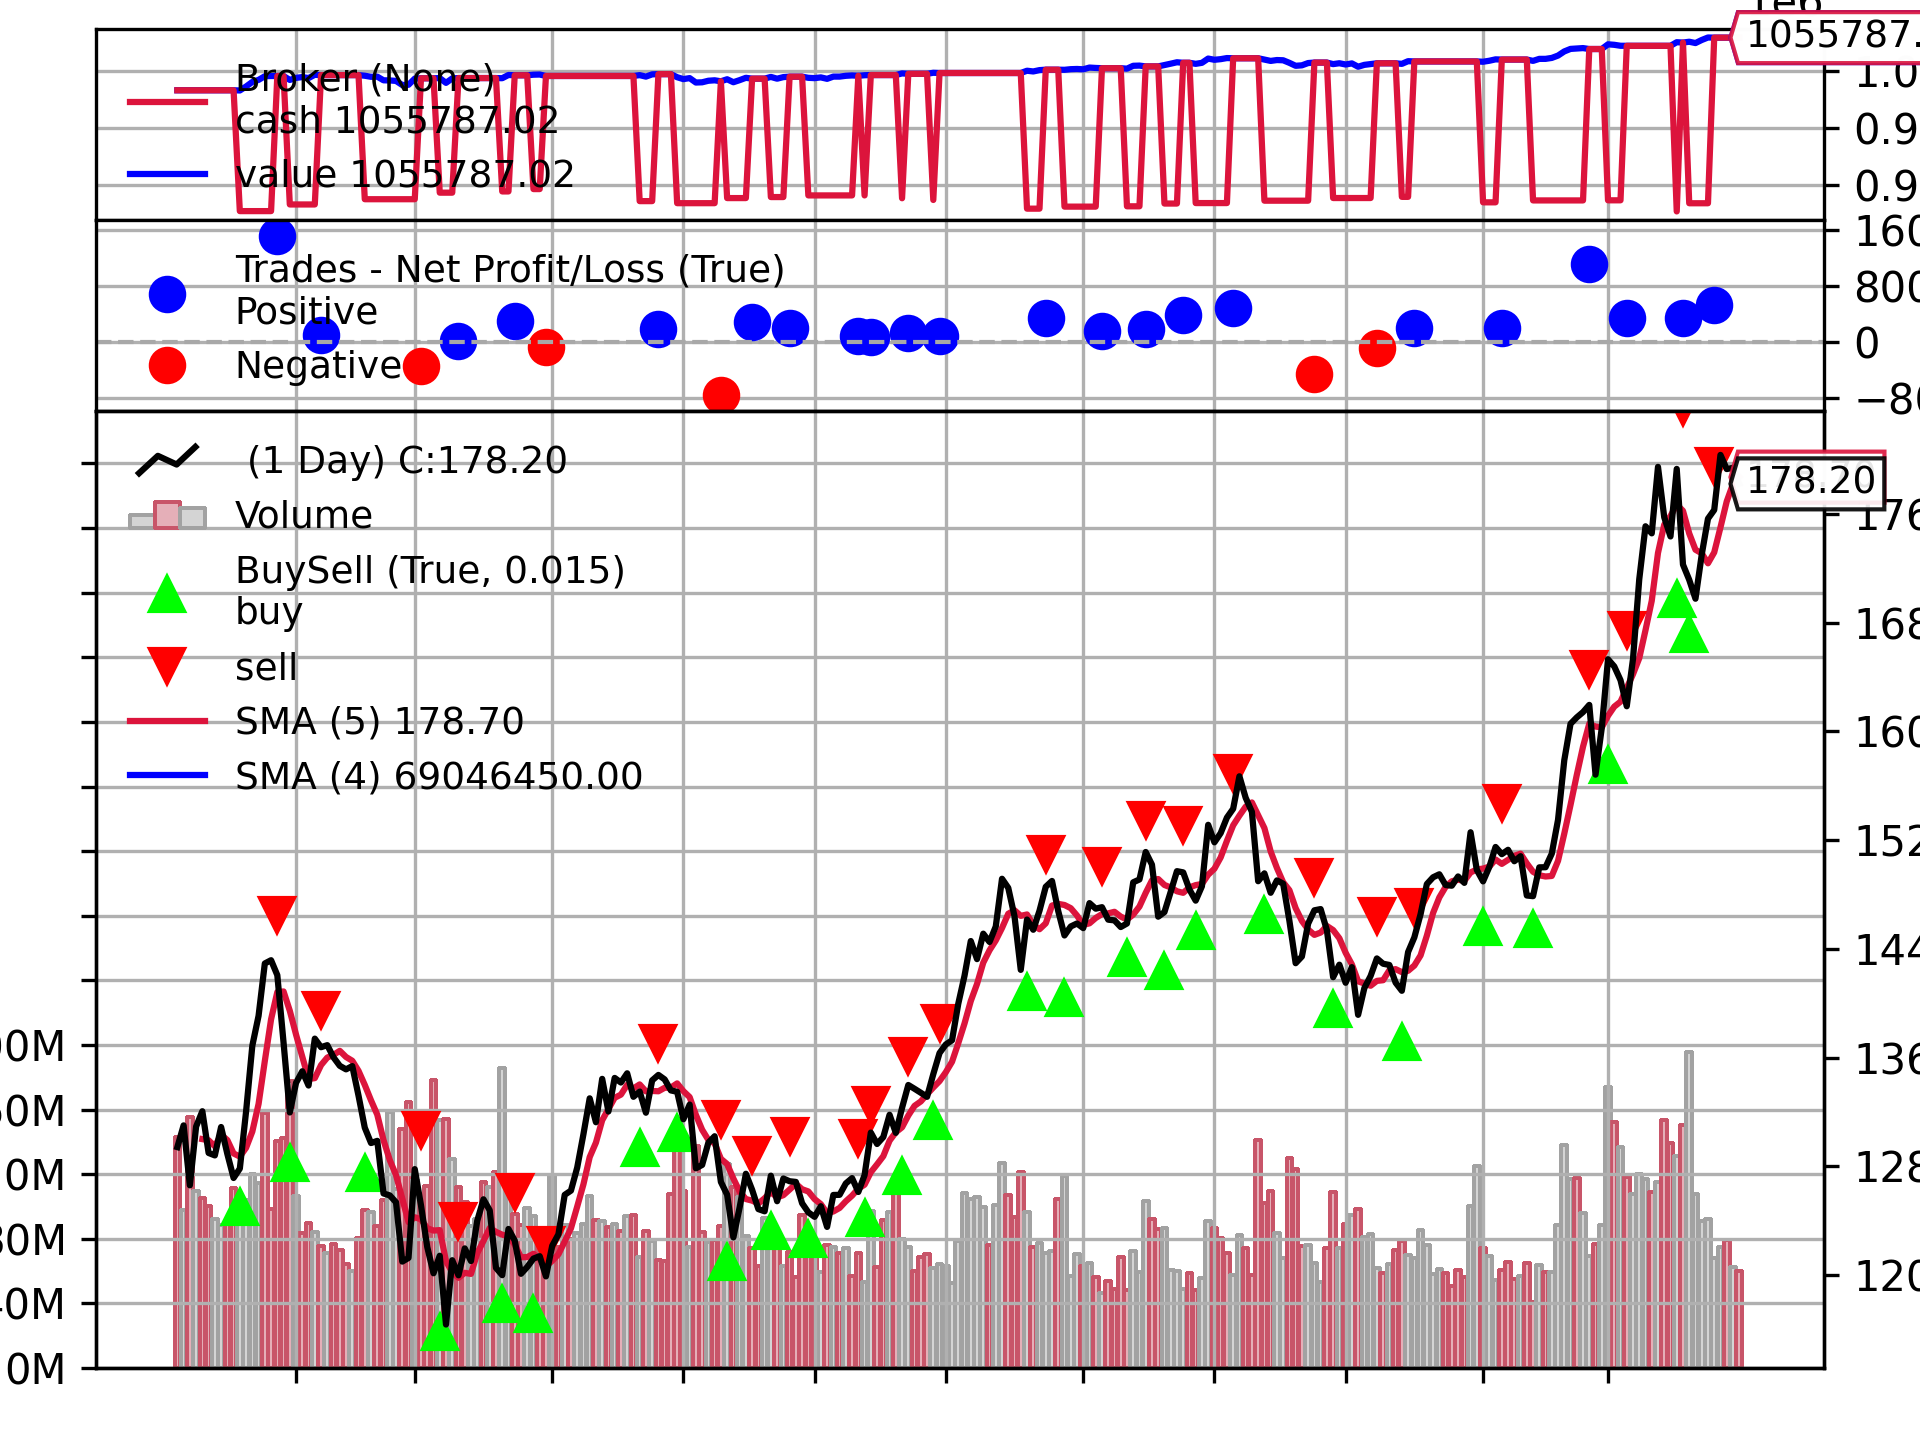

In [11]:
# Run the strategy & plot the results
cerebro = set_and_run(data,
                      FirstStrategy,
                      startcash,
                      commission,
                      stake)

chart_file = 'result.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())

# Second strategy: Short & long period SMA
- This strategy creates a short period SMA (e.g: 10-d SMA), and a longer one (60-d SMA), and then analyze the crossovers between the two to generate buy/sell signals:
- If the short period SMA is below the long period SMA, this means that the trend is going down, so it's a sell signal, it's also known as the death cross.
Otherwise, the trend is shiftting up, and it's a buy signal, it's also called the golden cross.

In [12]:
class SecondStrategy(bt.Strategy):
    params = (('short_period', 6),
              ('long_period', 98)
    )

    def __init__(self):
        self.short_period_sma = bt.indicators.SMA(self.data.close, period=self.params.short_period)
        self.long_period_sma = bt.indicators.SMA(self.data.close, period=self.params.long_period)

    def next(self):
        if not self.position:
            if self.short_period_sma > self.long_period_sma:
                self.buy()
        else:
            if self.short_period_sma < self.long_period_sma:
                self.sell()

In [13]:
# Backtesting the model's parameters
cerebro = bt.Cerebro()
cerebro.adddata(data)
strats = cerebro.optstrategy(SecondStrategy,
                             short_period=range(1, 30),
                             long_period=range(80, 120))
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission)
cerebro.addsizer(bt.sizers.FixedSize, stake=stake)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, factor=365)
cerebro.addanalyzer(bt.analyzers.VWR, timeframe=bt.TimeFrame.Days, tann=365)
results = cerebro.run()

df_result = pd.DataFrame([{"Short period": result[0].params.short_period,
                           "Long period": result[0].params.long_period,
                           "Sharpe ratio": result[0].analyzers.sharperatio.get_analysis()['sharperatio'],
                           "Variability weighted return (in %)": result[0].analyzers.vwr.get_analysis()['vwr']
                          } for result in results])
display(df_result.sort_values("Sharpe ratio", ascending=False))

,Short period,Long period,Sharpe ratio,Variability weighted return (in %)
218,6,98,0.107620,4.602863
74,2,114,0.103871,4.483696
194,5,114,0.103871,4.483696
187,5,107,0.103871,4.483696
188,5,108,0.103871,4.483696
...,...,...,...,...
840,22,80,0.047771,2.613042
800,21,80,0.046648,2.570673
920,24,80,0.045433,2.523594
600,16,80,0.044135,2.462214


Starting Portfolio Value: 1000000
Final Portfolio Value: 1049561.4441223145
Sharpe Ratio: 2.056074819088159


,Date,Gross PnL,Net PnL,Trade commission,Trade duration (in days)
0,2021-10-12,13429.99,12883.93,546.059998,117.0


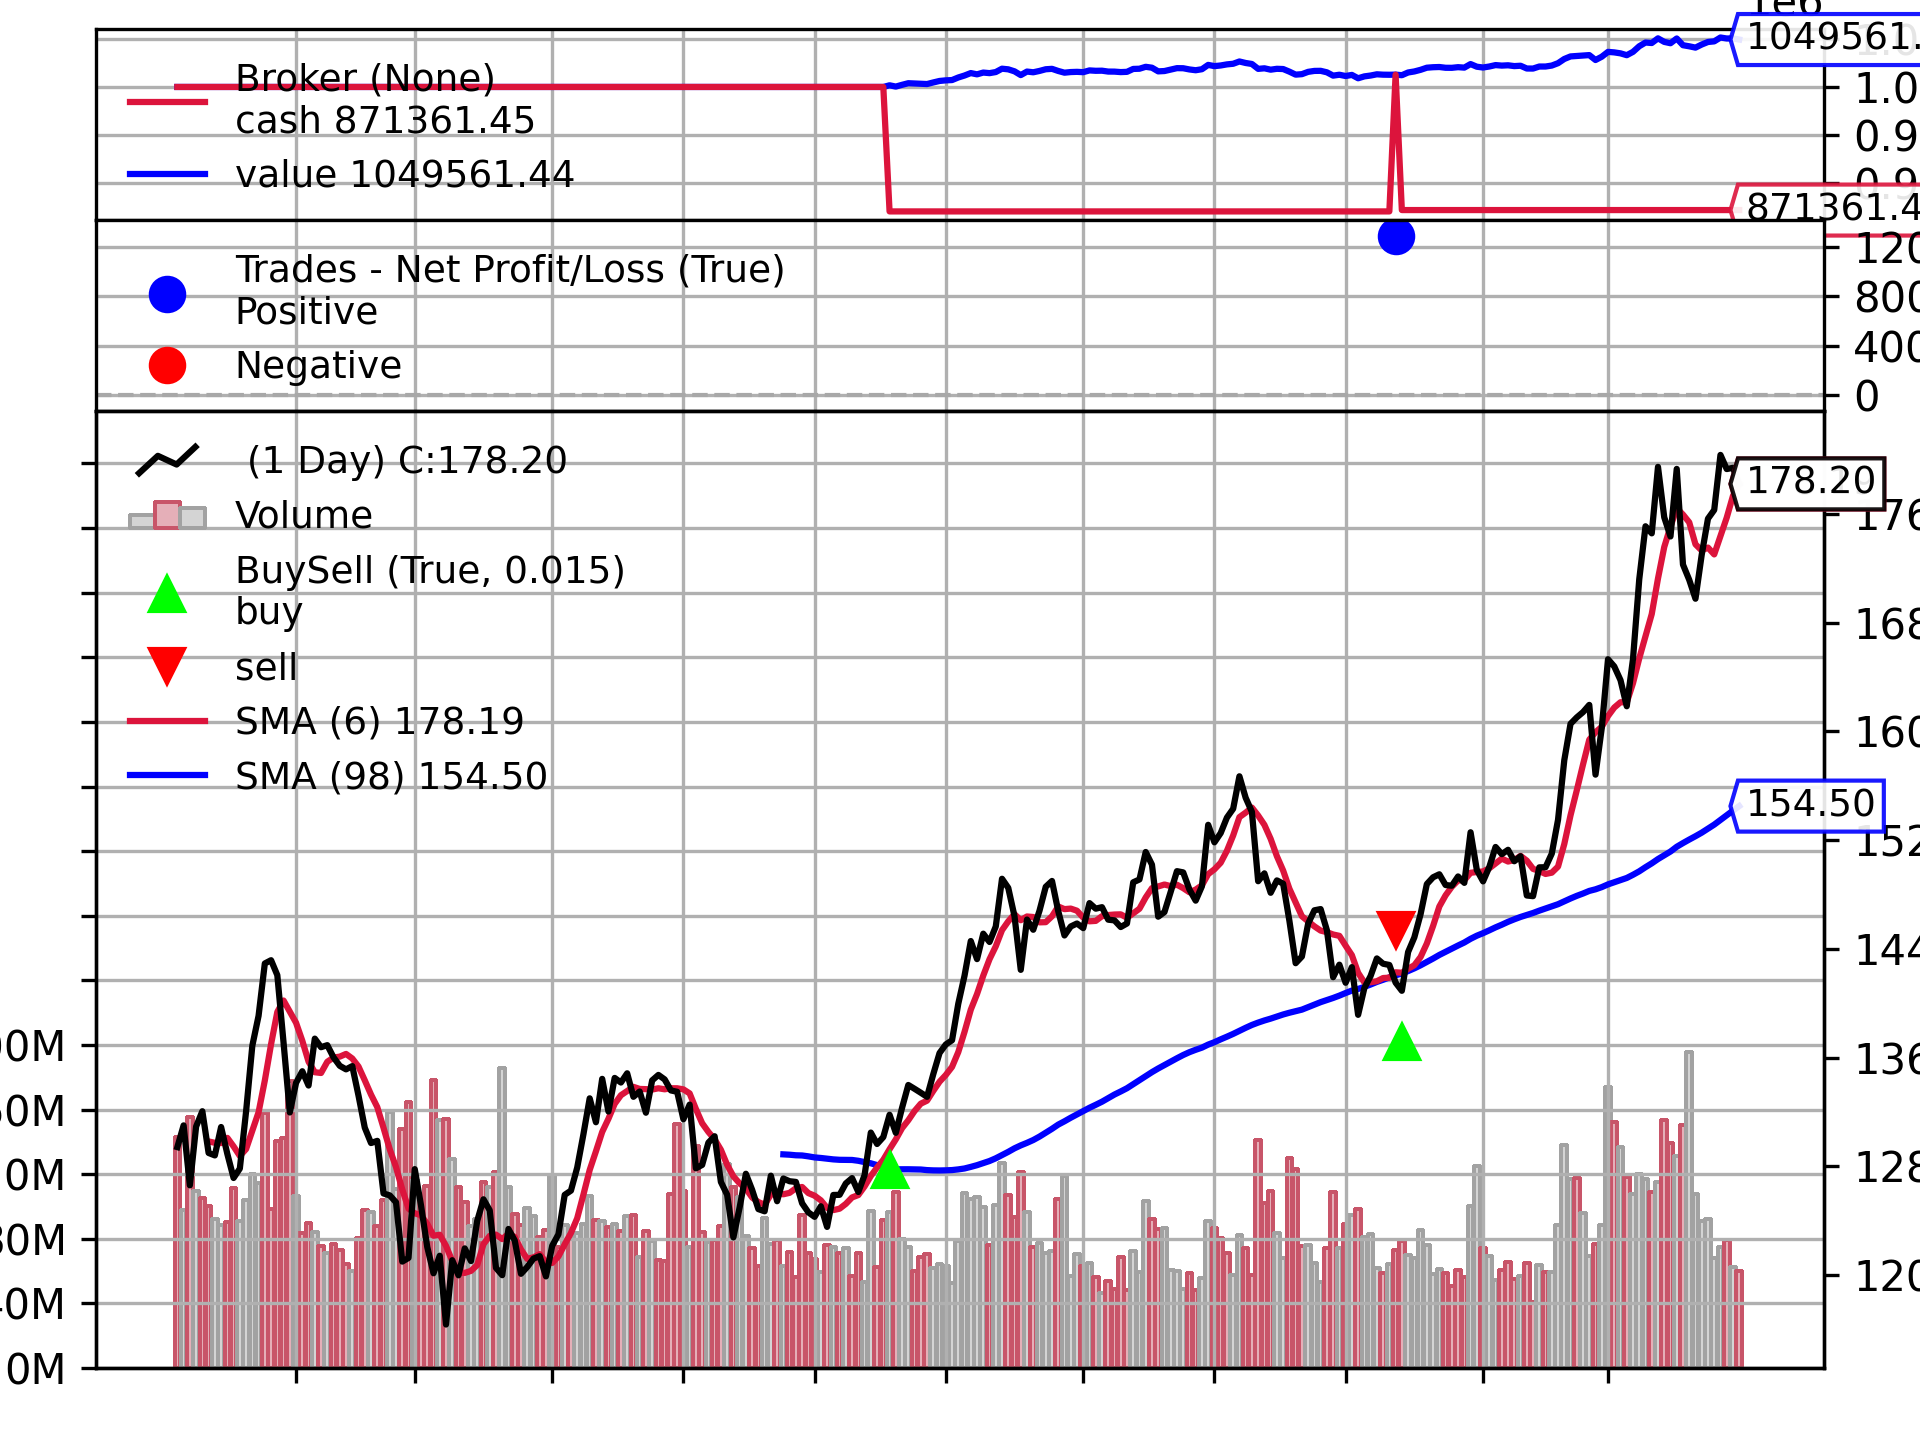

In [14]:
# Run the strategy & plot the results
cerebro = set_and_run(data,
                      SecondStrategy,
                      startcash,
                      commission,
                      stake)

plt.rcParams['figure.figsize'] = (16, 8)
chart_file = 'result.png'
cerebro.plot()[0][0].savefig(chart_file, dpi=300)
Image(open(chart_file, 'rb').read())